# Kernel Memory 快速开始

使用Kernel Memory 提供了多种运行方式，一种是以Service方式，一种是Serverless 方式。根据你的场景，你可能希望所有代码都在你的进程本地内部运行，或者通过异步可扩展的服务远程运行。二者的差异如下：


|对比项|同步方式（serverless模式）|异步方式（Web服务）|
|--|--|--|
|运行模式|在.NET后端/控制台/桌面应用中嵌入`MemoryServerless`类实例，以同步模式运行，每个请求会被立即处理|作为异步Web服务运行|
|适用场景|适用于导入小文件、仅使用C#语言且在导入过程中可阻塞进程的情况|适用于希望使用Web服务导入数据并发送查询获取答案；应用使用TypeScript、Java、Rust等语言；导入大文档，不想阻塞用户界面；需要内存导入独立运行，支持失败重试逻辑；想要定义混合多种语言（如Python、TypeScript等）的自定义管道等场景|
|优势|处理简单，请求处理即时|能处理大量文档和信息而不阻塞应用，可扩展性强，能支持复杂场景需求|
|劣势|调用客户端需负责处理瞬态错误；不适合处理大文档和复杂场景|/| 

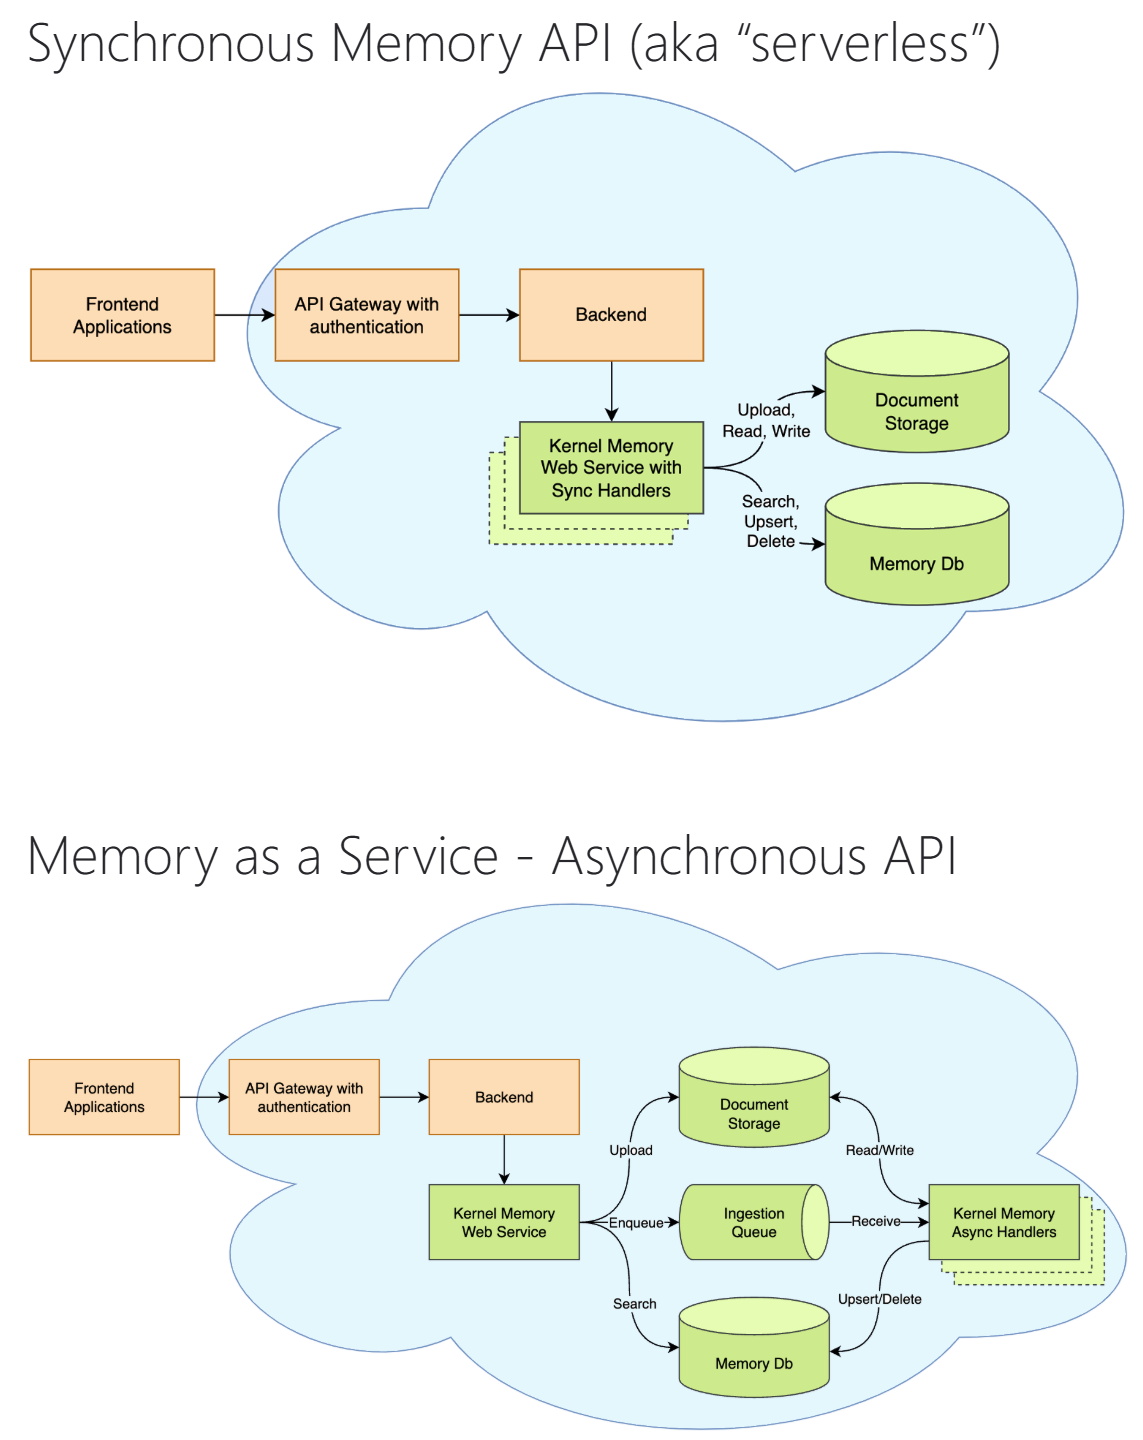




为了快速演示，直接使用Serverless方式。

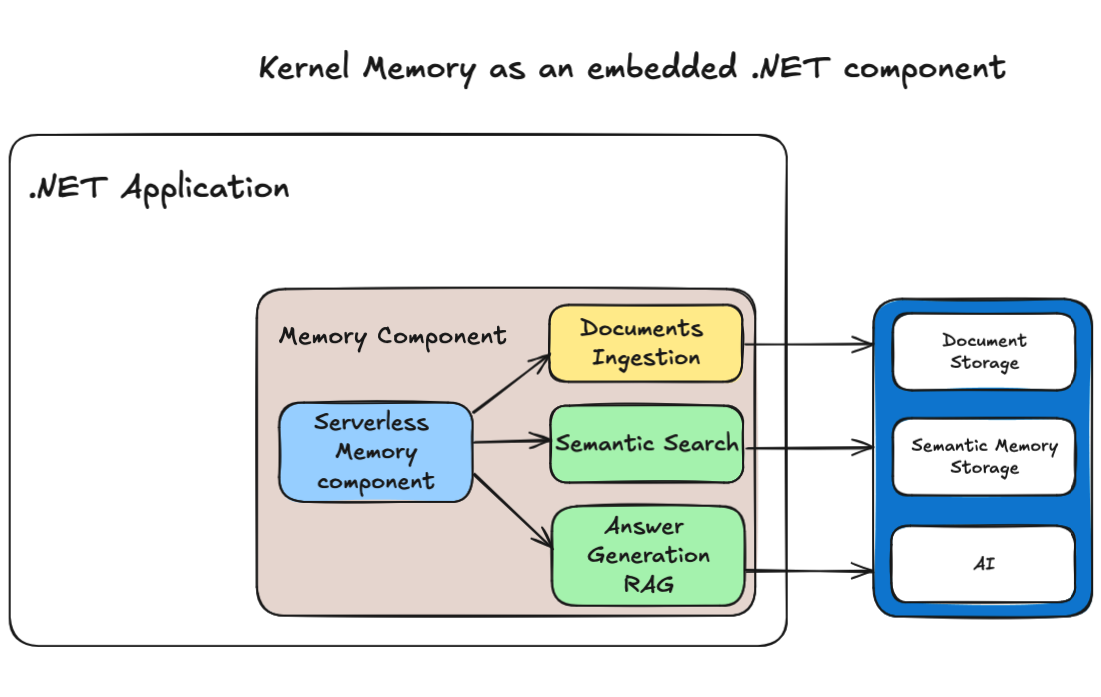

1. 安装 NuGet 包

In [8]:
// KM 核心库
#r "nuget: Microsoft.KernelMemory.Core" 
// 用于从.env 文件中读取配置
#r "nuget: dotenv.net"

#r "nuget: Microsoft.KernelMemory.AI.AzureOpenAI"

using Microsoft.KernelMemory;

Installed Packages dotenv.net, 3.2.1 Microsoft.KernelMemory.AI.AzureOpenAI, 0.98.250324.1 Microsoft.KernelMemory.Core, 0.98.250324.1

2. 创建 .env 文件

    创建[Config/.env](./Config/.env)文件用于定义配置，内容如下：
    ```
    AZURE_OPENAI_API_KEY=163ed6f8bc2947e0906d6ee5e173a222
    AZURE_OPENAI_ENDPOINT=https://my-openapi.openai.azure.com
    AZURE_CHAT_DEPLOYMENT=gpt-4o
    AZURE_EMBEDDINGS_DEPLOYMENT=text-embedding-ada-002
    ```

3. 加载配置

In [9]:
using dotenv.net;

// 读取配置
var env = DotEnv.Fluent()
    .WithEnvFiles("Config/.env")
    .WithExceptions()
    .WithTrimValues()
    .WithDefaultEncoding()
    .Read();

env.Display();

key,value
AZURE_OPENAI_API_KEY,163ed6f8bc2947e0906d6ee5e173a222
AZURE_OPENAI_ENDPOINT,https://my-openapi.openai.azure.com
AZURE_CHAT_DEPLOYMENT,gpt-4o
AZURE_EMBEDDINGS_DEPLOYMENT,text-embedding-ada-002
MEMORY_API_KEY,163ed6f8bc2947e0906d6ee5e173a222
MEMORY_ENDPOINT,https://my-openapi.openai.azure.com


4. 初始化 Memory


    以下使用的是Azure OpenAI 提供的Embedding 和文本生成服务，并指定使用内置的简易文档存储和记忆存储。

In [10]:
using Microsoft.KernelMemory.DocumentStorage.DevTools;
using Microsoft.KernelMemory.FileSystem.DevTools;
using Microsoft.KernelMemory.MemoryStorage.DevTools;

var chatConfig = new AzureOpenAIConfig()
{  
    Auth= AzureOpenAIConfig.AuthTypes.APIKey,
    Endpoint = env["AZURE_OPENAI_ENDPOINT"],
    APIKey = env["AZURE_OPENAI_API_KEY"],
    Deployment = env["AZURE_CHAT_DEPLOYMENT"]
};
var embeddingConfig = new AzureOpenAIConfig()
{  
    Auth= AzureOpenAIConfig.AuthTypes.APIKey,
    Endpoint = env["AZURE_OPENAI_ENDPOINT"],
    APIKey = env["AZURE_OPENAI_API_KEY"],
    Deployment = env["AZURE_EMBEDDINGS_DEPLOYMENT"]
};

// 配置文件存储，用于存储生成的文件，存储在本地磁盘的 tmp_files 目录下
var simpleFileStorageConfig = new SimpleFileStorageConfig()
{
    StorageType = FileSystemTypes.Disk,
    Directory = "tmp_files"
};

// 配置向量数据库，用于存储生成的向量，存储在本地磁盘的 tmp_vectors 目录下
var simpleVectorDbConfig = new SimpleVectorDbConfig()
{
    StorageType = FileSystemTypes.Disk,
    Directory = "tmp_vectors"
};

var memory = new KernelMemoryBuilder()
    .WithAzureOpenAITextEmbeddingGeneration(embeddingConfig) // 使用 Azure OpenAI 作为文本嵌入生成器
    .WithAzureOpenAITextGeneration(chatConfig) // 使用 Azure OpenAI 作为文本生成器
    .WithSimpleFileStorage(simpleFileStorageConfig)
    .WithSimpleVectorDb(simpleVectorDbConfig)
    .Build<MemoryServerless>();

memory.Display()

Microsoft.KernelMemory.MemoryServerless Orchestrator Microsoft.KernelMemory.Pipeline.InProcessPipelineOrchestrator HandlerNames [ delete_generated_files, extract, gen_embeddings, gen_embeddings_parallel, partition, private_delete_document, private_delete_index, save_records, summarize, summarize_parallel ] EmbeddingGenerationEnabled True

5. 导入文档

导入一个简要介绍KM的文档：[Config/KM_Overview.pdf](Config/KM_Overview.pdf)

In [11]:
var doc = await memory.ImportDocumentAsync("Config/KM_Overview.pdf");

doc.Display();

091fc40c7db844c9b27e183e42412f51202504031024146472807

6. Q&A

In [12]:
var question = "What's Kernel Memory?";

var answer = await memory.AskAsync(question, minRelevance: 0.85);

Console.WriteLine($"Q: {question}\n\nA: {answer.Result}");

answer.Display();

Q: What's Kernel Memory?

A: Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available as a Web Service, a Docker container, a Plugin for ChatGPT/Copilot/Semantic Kernel, and as a .NET library for embedded applications. It utilizes advanced embeddings and large language models (LLMs) to enable natural language querying for obtaining answers from indexed data, complete with citations and links to the original sources.

KM is designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot, and ChatGPT, enhancing data-driven features in applications built for popular AI platforms. It works best as an asynchronous Web Service, allowing the ingestion of thousands of documents and information without blocking the application. However, it can also ru

Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available as a Web Service,... StreamState <null> Question What's Kernel Memory? NoResult False NoResultReason <null> Result Kernel Memory (KM) is a multi-modal AI service designed for efficient indexing of datasets through custom continuous data hybrid pipelines. It supports Retrieval Augmented Generation (RAG), synthetic memory, prompt engineering, and custom semantic memory processing. KM is available as a Web Service, a Docker container, a Plugin for ChatGPT/Copilot/Semantic Kernel, and as a .NET library for embedded applications. It utilizes advanced embeddings and large language models (LLMs) to enable natural language querying for obtaining answers from indexed data, complete with citations and links to the original sources.

KM is designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot, and ChatGPT, enhancing data-driven features in applications built for popular AI platforms. It works best as an asynchronous Web Service, allowing the ingestion of thousands of documents and information without blocking the application. However, it can also run in serverless mode, embedding a MemoryServerless class instance in .NET backend/console/desktop apps in synchronous mode. This approach is also applicable in ASP.NET Web APIs and Azure Functions.

Kernel Memory can be deployed as a backend service, supporting custom pipelines that mix multiple languages like Python, TypeScript, etc., and leveraging an asynchronous non-blocking memory encoding process. It provides several features that would otherwise need to be developed manually, such as storing files, extracting text from files, and providing a framework to secure users' data. The KM codebase is entirely in .NET, making it accessible from any TokenUsage index value 0 Microsoft.KernelMemory.TokenUsage Timestamp 2025-04-03 02:25:08Z ServiceType Azure OpenAI ModelType TextGeneration ModelName gpt-4o TokenizerTokensIn 901 TokenizerTokensOut 299 ServiceTokensIn 907 ServiceTokensOut 300 ServiceReasoningTokens 0 RelevantSources index value 0 Microsoft.KernelMemory.Citation Link default/091fc40c7db844c9b27e183e42412f51202504031024146472807/5b805952b1cb4ab680d0e24622e37d3a Index default DocumentId 091fc40c7db844c9b27e183e42412f51202504031024146472807 FileId 5b805952b1cb4ab680d0e24622e37d3a SourceContentType application/pdf SourceName KM_Overview.pdf SourceUrl /download?index=default&documentId=091fc40c7db844c9b27e183e42412f51202504031024146472807&filename=KM_Overview.pdf Partitions index value 0 Microsoft.KernelMemory.Citation+Partition Text licenselicense MITMIT DiscordDiscord 404 online404 online
Kernel Memory (KM) is a multi-modal AI Service specialized in the efficient indexing of datasets
through custom continuous data hybrid pipelines, with support for Retrieval Augmented Generation (
RAG), synthetic memory, prompt engineering, and custom semantic memory processing.
KM is available as a Web Service, as a Docker container, a Plugin for ChatGPT/Copilot/Semantic
Kernel, and as a .NET library for embedded applications.
Utilizing advanced embeddings and LLMs, the system enables Natural Language querying for obtaining
answers from the indexed data, complete with citations and links to the original sources.
Designed for seamless integration as a Plugin with Semantic Kernel, Microsoft Copilot and ChatGPT,
Kernel Memory enhances data-driven features in applications built for most popular AI platforms.
Kernel Memory works and scales at best when running as an asynchronous Web Service, allowing to
ingest thousands of documents and information without blocking your app.
However, Kernel Memory can also run in serverless mode, embedding MemoryServerless class instance in
.NET backend/console/deskt

7. 查看生成的文件存储和记忆存储

文件存储在配置的`tmp_files`目录下，记忆存储在配置的`tmp_vectors`下。